<a href="https://colab.research.google.com/github/Sai-Chakradhar-Mahendrakar/Implementation-of-RAG-using-ChromaDB-and-BERT/blob/main/RAG_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of RAG Model using Chromadb and BERT Embeddings

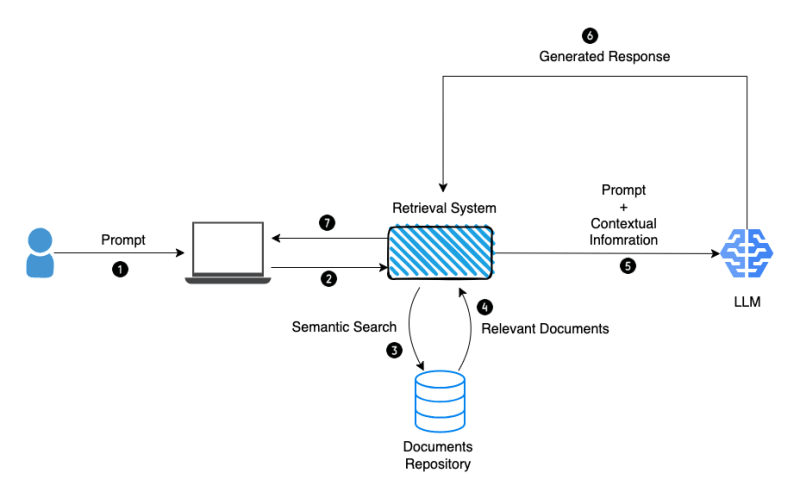

In [ ]:
!pip install chromadb

## Importing libraries

In [ ]:
import chromadb
from rich import print
from transformers import BertTokenizer, BertModel
import torch

## Loading BERT model and tokenizer from Hugging Face

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Function to get BERT embeddings for a given text prompt

In [ ]:
def get_bert_embeddings(prompt):
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().tolist()

## Function to add documents to the database

In [ ]:
def add_documents_to_chromadb(documents, db_path):
    client = chromadb.Client()

    try:
        collection = client.get_collection(name="docs")
    except Exception as e:
        print(f"Collection not found, creating a new one. Error: {e}")
        collection = client.create_collection(name="docs")

    for i, doc in enumerate(documents):
        content = doc["content"]
        embedding = get_bert_embeddings(content)

        try:
            collection.add(
                ids=[str(i)],
                embeddings=[embedding],
                documents=[content],
                metadatas=[{"dept": doc["dept"]}]
            )
        except Exception as e:
            print(f"Failed to add document {i} to collection. Error: {e}")

## Function for searching document in database

In [ ]:
def search_department_in_chromadb(db_path, department, query, n_results):
    client = chromadb.Client()

    try:
        collection = client.get_collection("docs")
    except Exception as e:
        print(f"Failed to retrieve collection 'docs'. Error: {e}")
        return []

    query_embedding = get_bert_embeddings(query)

    try:
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            where={"dept": department}
        )
        return results
    except Exception as e:
        print(f"Failed to search in collection. Error: {e}")
        return []

In [ ]:
documents = [
    {"dept": "HR", "content": "HR is responsible for recruiting new employees."},
    {"dept": "HR", "content": "HR handles employee benefits and payroll."},
    {"dept": "IT", "content": "IT manages the company’s internal network."},
    {"dept": "IT", "content": "IT provides technical support to employees."},
    {"dept": "Finance", "content": "Finance manages the company’s budget."},
    {"dept": "Finance", "content": "Finance oversees all financial transactions."},
    {"dept": "Marketing", "content": "Marketing handles the promotion of products."},
    {"dept": "Marketing", "content": "Marketing analyzes market trends and competitors."}
]

## Add documents to the ChromaDB

In [ ]:
db_path = "docs/"
add_documents_to_chromadb(documents, db_path)

## Search for documents in the IT department related to "network"

In [ ]:
department = "IT"
query = "network"
n_results = 2
search_results = search_department_in_chromadb(db_path, department, query, n_results)

In [ ]:
print(search_results)

{
    'ids': [['3', '2']],
    'distances': [[51.35449981689453, 60.33723449707031]],
    'metadatas': [[{'dept': 'IT'}, {'dept': 'IT'}]],
    'embeddings': None,
    'documents': [['IT provides technical support to employees.', 'IT manages the company’s internal network.']],
    'uris': None,
    'data': None,
    'included': ['metadatas', 'documents', 'distances']
}